### Imports

In [166]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import constants, utils
import numpy as np
import json
from typing import Annotated, Any

from langchain_openai import ChatOpenAI
from langgraph.constants import Send
from langchain_core.messages import HumanMessage, SystemMessage

import prompts

os.environ["OPENAI_API_KEY"] = utils.get_openai_api_key()
os.environ["TAVILY_API_KEY"] = utils.get_tavily_api_key()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Defining the State

In [167]:
import operator
from typing import Annotated, List, Tuple, TypedDict, Optional
from epub_parser import EPUB, ContentNode, Metadata
from dataclasses import dataclass

class ChapterSummary(BaseModel):
    chapter: ContentNode # Chapter Object 
    chapter_summary: str # Summary of the chapter
    
    class Config:
        arbitrary_types_allowed = True  # Allow arbitrary types such as EPUB

class BookSummarizerState(BaseModel):
    book_name: Annotated[str, Field(description="Name of the book")]  # Name of the book
    verbose: int  # Verbosity level: 0 (silent), 1 (verbose)
    book_dir: str  # Directory of the book
    book: Optional[EPUB] = None  # EPUB object
    chapter_titles_all: List[str] = []  # List of all chapter titles
    chapter_titles_to_summarize: List[str] = []  # List of chapter titles to summarize
    chapters_to_summarize: List[ContentNode] = []  # List of the chapters to summarize
    num_chapters_to_summarize: int  # Number of chapters to summarize
    chapter_summaries: Annotated[List[ChapterSummary], operator.add] = []  # List of summaries of the chapters
    final_summary: str = ""  # Final summary of the book

    class Config:
        arbitrary_types_allowed = True  # Allow arbitrary types such as EPUB

class BookSummarizerStateSummarizerAgent(BaseModel):
    index_chapter_to_summarize: int # Index of the chapter to summarize
    book_summarizer_state: BookSummarizerState # State of the book summarizer


### Agents

#### Summarizer Agent

In [168]:
from langchain import hub
from langchain_openai import ChatOpenAI
# Import chain type
from langchain.chains import LLMChain
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.pydantic_v1 import BaseModel, Field

class Response(BaseModel):
    """Response to user."""

    response: str

class AgentSectionSummarizer():
    """Agent that summarizes a section of a book."""
    system_prompt: str # System prompt for the agent
    user_prompt: str # User prompt for the agent
    llm: LLMChain # LLM powering the agent
    prompt_template: ChatPromptTemplate # Prompt given to the agent 
    agent: Any # Final agent which is a combination of the prompt and the LLM Chain


    def __init__(self):
        self.system_prompt = prompts.SECTION_SUMMARIZER_SYSTEM_PROMPT
        self.user_prompt = prompts.SECTION_SUMMARIZER_USER_PROMPT
        self.llm = ChatOpenAI(model=constants.MODEL_NAME).with_structured_output(Response)
        self.prompt_template = ChatPromptTemplate.from_messages(
            [("system", self.system_prompt), ("user", self.user_prompt)]
        )
        self.agent = self.prompt_template | self.llm

    def __call__(self, state: BookSummarizerStateSummarizerAgent) -> Any:
        print("State: ", state, "\n SUMMARIZING CHAPTER ", str(state.index_chapter_to_summarize)) if state.book_summarizer_state.verbose == 1 else None
        
        # Obtain the chapter to summarize and summarize it with the summarizer agent
        index_chapter_to_summarize = state.index_chapter_to_summarize
        chapters_to_summarize = state.book_summarizer_state.chapters_to_summarize
        chapter_to_summarize = chapters_to_summarize[index_chapter_to_summarize]
        agent_response = self.agent.invoke({"section":  chapter_to_summarize.content})
        summary = agent_response.response
        chapter_summary = ChapterSummary(chapter=chapter_to_summarize, chapter_summary=summary)

        print("\n\n SUMMARY of CHAPTER: ", chapter_to_summarize.title, "\n\n", summary) if state.book_summarizer_state.verbose == 1 else None
        return {"chapter_summaries": [chapter_summary]}

#### Relevant Chapter Selection Agent

In [169]:
from langchain import hub
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Tuple, TypedDict

from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.pydantic_v1 import BaseModel, Field

class ChapterList(BaseModel):
    """Response to user."""

    chapter_list: List[str]


system_template = "You are an agent helping to summarize a book parsed from an epub. The first step is to select the chapters which are relevant to summarize"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "Select the chapters which are relevant to summarize: {chapter_list}")]
)

llm = ChatOpenAI(model=constants.MODEL_NAME).with_structured_output(ChapterList)
chapter_selector_agent = prompt_template | llm

chapters = [
    "Cover",
    "Title",
    "Copyright",
    "Dedication",
    "Contents",
    "Preface",
    "Introduction: Eat That Frog",
    "1 Set the Table",
    "2 Plan Every Day in Advance",
    "3 Apply the 80/20 Rule to Everything",
    "4 Consider the Consequences",
    "5 Practice Creative Procrastination",
    "6 Use the ABCDE Method Continually",
    "7 Focus on Key Result Areas",
    "8 Apply the Law of Three",
    "9 Prepare Thoroughly Before You Begin",
    "10 Take It One Oil Barrel at a Time",
    "11 Upgrade Your Key Skills",
    "12 Identify Your Key Constraints",
    "13 Put the Pressure on Yourself",
    "14 Motivate Yourself into Action",
    "15 Technology Is a Terrible Master",
    "16 Technology Is a Wonderful Servant",
    "17 Focus Your Attention",
    "18 Slice and Dice the Task",
    "19 Create Large Chunks of Time",
    "20 Develop a Sense of Urgency",
    "21 Single Handle Every Task",
    "Conclusion: Putting It All Together",
    "Notes",
    "Index",
    "Learning Resources",
    "About"
]

# chapter_selector_agent.invoke({"chapter_list": chapters})

#### Summaries Aggregator Agent

In [170]:
system_template = """You are an expert summarizer. You are working with other summarizers to summarize a complete book.   
    Other summarizers have already summarized their respective chapters. You are now tasked with summarizing the entire 
    book based on the summaries provided by the other summarizers. The summary should be detailed and cover all the
    important points from each chapter. It should be around 6 paragraphs long."""
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "Chapter Summaries: \n" + "{text} \n---\n Complete book summary:")]
)

chapter_summaries = "Chapter 1: This chapter is about setting the table.\nChapter 2: This chapter is about planning every day in advance.\nChapter 3: This chapter is about applying the 80/20 rule to everything"

llm = ChatOpenAI(model=constants.MODEL_NAME).with_structured_output(Response)
summaries_aggreagator = prompt_template | llm
summaries_aggreagator.invoke({"text": chapter_summaries})

Response(response='The book emphasizes the importance of effective time management and productivity through various strategies. In Chapter 1, the focus is on setting the table, possibly referring to setting the foundation or groundwork for success. Chapter 2 highlights the significance of planning each day in advance to maximize productivity and efficiency. Chapter 3 introduces the concept of the 80/20 rule, suggesting that focusing on the most critical 20% of tasks can lead to 80% of the results. These chapters collectively stress the need for intentional planning and prioritization to achieve optimal outcomes in personal and professional endeavors.')

### Functions for the Graph

In [171]:
from typing import Literal

def load_epub(state: BookSummarizerState):
    print("State: ", state, "\n SAVING SUMMARY") if state.verbose == 1 else None
    book = EPUB(state.book_dir)
    
    chapter_titles_all = []
    for node in book.root_node.children:
        chapter_titles_all.append(node.title)
    
    state.book = book
    state.chapter_titles_all = chapter_titles_all

    print("\n\n "+str(len(chapter_titles_all))+" chapters found in the book") 

    if state.num_chapters_to_summarize is None:
        state.num_chapters_to_summarize = len(chapter_titles_all)

    return state

def select_chapters_to_summarize(state: BookSummarizerState):
    print("State: ", state, "\n SELECTING CHAPTERS") if state.verbose == 1 else None
    
    chapters = state.chapter_titles_all
    chapter_titles_to_summarize = chapter_selector_agent.invoke({"chapter_list": chapters})
    state.chapter_titles_to_summarize = chapter_titles_to_summarize.chapter_list
    
    return state

def load_selected_chapters(state: BookSummarizerState):
    print("State: ", state, "\n LOADING SELECTED CHAPTERS") if state.verbose == 1 else None
    chapter_titles_to_summarize = state.chapter_titles_to_summarize
    book = state.book
    chapter_contents = []
    num_chapters_to_summarize = state.num_chapters_to_summarize

    num_chapters = 0
    for node in book.root_node.children:
        if num_chapters < num_chapters_to_summarize:
            if node.title in chapter_titles_to_summarize:
                chapter_contents.append(node)
                num_chapters += 1
        else:
            break
    state.chapters_to_summarize = chapter_contents
    return state

def send_to_summarizer_agents(state: BookSummarizerState):
    # We will return a list of `Send` objects. Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    print("verbose: ", state.verbose)
    print("State: ", state, "\n SENDING TO SUMMARIZER AGENTS") if state.verbose == 1 else None
    sends = []
    # [Send("summarizer_agent", {"index_chapter_to_summarize": i, "book_summarizer_state": state}) for i in range(len(state.chapters_to_summarize))]
    for i in range(state.num_chapters_to_summarize):
        state_summarizer_agent = BookSummarizerStateSummarizerAgent(index_chapter_to_summarize=i, book_summarizer_state=state)
        sends.append(Send("summarizer_agent", state_summarizer_agent))
    print("Sends: ", sends) if state.verbose == 1 else None
    return sends

def summaries_aggregator_agent(state: BookSummarizerState):
    print("State: ", state, "\n AGGREGATING CHAPTERS") if state.verbose == 1 else None

    # Construct the string to submit to the summaries aggregator agent
    chapter_summaries = ""
    for chapter_summary in state.chapter_summaries:
        chapter_summaries += "Chapter: " + chapter_summary.chapter.title + "\nSummary: " + chapter_summary.chapter_summary + "\n\n"
    
    # Summarize the complete book
    agent_response = summaries_aggreagator.invoke({"text": chapter_summaries})
    state.final_summary = agent_response.response

    print("\n\nFINAL SUMMARY: \n\n", agent_response.response) if state.verbose == 1 else None
    return state

def show_results(state: BookSummarizerState):
    print("State: ", state, "\n SHOWING RESULTS") if state.verbose == 1 else None
    for i, response in enumerate(state.chapter_summaries):
        print("Chapter: ", response.chapter.title)
        print("Summary: ", response.chapter_summary)
        print("\n\n")
    
    # Save the final summary to a json file
    file_name = state.book_name.replace(" ", "_") + "--"+constants.MODEL_NAME+"--summary.json"
        # The content should be a dictionary with the epub file name as the key and the final summary as the value
    content = {state.book_name.replace(" ", "_"): state.final_summary}
    # Save the dictionary to a JSON file
    with open(file_name, 'w') as json_file:
        json.dump(content, json_file, indent=4)

    print("\n\nFinal Summary: ", state.final_summary)

### Create the Graph

In [172]:
from langgraph.graph import StateGraph

graph = StateGraph(BookSummarizerState)

graph.add_node("load_epub", load_epub)
graph.add_node("select_chapters_to_summarize", select_chapters_to_summarize)
graph.add_node("load_selected_chapters", load_selected_chapters)
graph.add_node("send_to_summarizer_agents", send_to_summarizer_agents)
graph.add_node("summarizer_agent", AgentSectionSummarizer())
graph.add_node("summaries_aggregator_agent", summaries_aggregator_agent)
graph.add_node("show_results", show_results)


graph.set_entry_point("load_epub")

graph.add_edge("load_epub", "select_chapters_to_summarize")
graph.add_edge("select_chapters_to_summarize", "load_selected_chapters")
graph.add_conditional_edges("load_selected_chapters", send_to_summarizer_agents)
graph.add_edge("summarizer_agent", "summaries_aggregator_agent")
graph.add_edge("summaries_aggregator_agent", "show_results")
graph.add_edge("show_results", "__end__")

app = graph.compile()

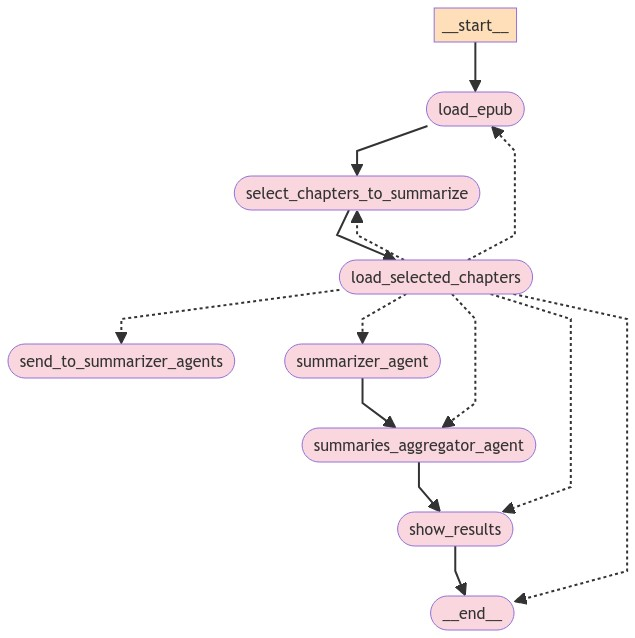

In [173]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### Execute the Graph


In [174]:
config = {"recursion_limit": 50}
# book_name = "Eat that Frog!"
book_name = "eat_that_frog"
# book_dir = constants.BOOKS_DIR + 'eat_that_frog.epub'
book_dir = constants.BOOKS_DIR + "eat_that_frog.epub"
num_chapters_to_summarize = 3
verbose = 1
inputs = {"book_name": book_name, "book_dir": book_dir, "num_chapters_to_summarize": num_chapters_to_summarize, "verbose": verbose}
# inputs = (book_name=book_name, book_dir= book_dir, num_chapters_to_summarize= num_chapters_to_summarize, verbose= verbose)
book_config = BookSummarizerState(**inputs)
print(book_config.dict())

for event in app.stream(book_config.dict(), config=config):
    print("Event:", event)


{'book_name': 'eat_that_frog', 'verbose': 1, 'book_dir': '/home/pedro/Documents/GitHub/SwarmGPT/data/books/eat_that_frog.epub', 'book': None, 'chapter_titles_all': [], 'chapter_titles_to_summarize': [], 'chapters_to_summarize': [], 'num_chapters_to_summarize': 3, 'chapter_summaries': [], 'final_summary': ''}
State:  book_name='eat_that_frog' verbose=1 book_dir='/home/pedro/Documents/GitHub/SwarmGPT/data/books/eat_that_frog.epub' book=None chapter_titles_all=[] chapter_titles_to_summarize=[] chapters_to_summarize=[] num_chapters_to_summarize=3 chapter_summaries=[] final_summary='' 
 SAVING SUMMARY


 33 chapters found in the book
Event: {'load_epub': {'book_name': 'eat_that_frog', 'verbose': 1, 'book_dir': '/home/pedro/Documents/GitHub/SwarmGPT/data/books/eat_that_frog.epub', 'book': <epub_parser.EPUB object at 0x7fa5fe8fbc40>, 'chapter_titles_all': ['Cover Page', 'Title Page', 'Copyright Page', 'Dedication', 'Contents', 'Preface', 'Introduction: Eat That Frog', '1 Set the Table', '2 Pl

/home/pedro/Documents/Virtual-Environments/ai/lib/python3.10/site-packages/ebooklib/epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')
/home/pedro/Documents/Virtual-Environments/ai/lib/python3.10/site-packages/ebooklib/epub.py:1423: FutureWarning: This search incorrectly ignores the root element, and will be fixed in a future version.  If you rely on the current behaviour, change it to './/xmlns:rootfile[@media-type]'
  for root_file in tree.findall('//xmlns:rootfile[@media-type]', namespaces={'xmlns': NAMESPACES['CONTAINERNS']}):


Event: {'select_chapters_to_summarize': {'book_name': 'eat_that_frog', 'verbose': 1, 'book_dir': '/home/pedro/Documents/GitHub/SwarmGPT/data/books/eat_that_frog.epub', 'book': <epub_parser.EPUB object at 0x7fa5fe8fbc40>, 'chapter_titles_all': ['Cover Page', 'Title Page', 'Copyright Page', 'Dedication', 'Contents', 'Preface', 'Introduction: Eat That Frog', '1 Set the Table', '2 Plan Every Day in Advance', '3 Apply the 80/20 Rule to Everything', '4 Consider the Consequences', '5 Practice Creative Procrastination', '6 Use the ABCDE Method Continually', '7 Focus on Key Result Areas', '8 Apply the Law of Three', '9 Prepare Thoroughly Before You Begin', '10 Take It One Oil Barrel at a Time', '11 Upgrade Your Key Skills', '12 Identify Your Key Constraints', '13 Put the Pressure on Yourself', '14 Motivate Yourself into Action', '15 Technology Is a Terrible Master', '16 Technology Is a Wonderful Servant', '17 Focus Your Attention', '18 Slice and Dice the Task', '19 Create Large Chunks of Time',